<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/ensemble-methods-for-machine-learning/02-homogeneous-parallel-ensembles/01_bagging_bootstrap_aggregating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Bagging: Bootstrap aggregating

Bagging is the most basic homogeneous parallel ensemble method we can construct.

Bagging uses the same base machine-learning algorithm to train base estimators. 

So how can we get multiple base estimators from a single data set and a single learning
algorithm, let alone diversity? 

This comes by training base estimators on replicates of the
data set. Bagging consists of two steps:

1. During training, bootstrap sampling, or sampling with replacement, is used to generate replicates of the training data set that are different from each other but drawn from the original data set. This ensures that base learners trained on each of the replicates are also different from each other.

2. During prediction, model aggregation is used to combine the predictions of
the individual base learners into one ensemble prediction. For classification
tasks, we can combine individual predictions using majority voting. For regression tasks, we can combine individual predictions using simple averaging.

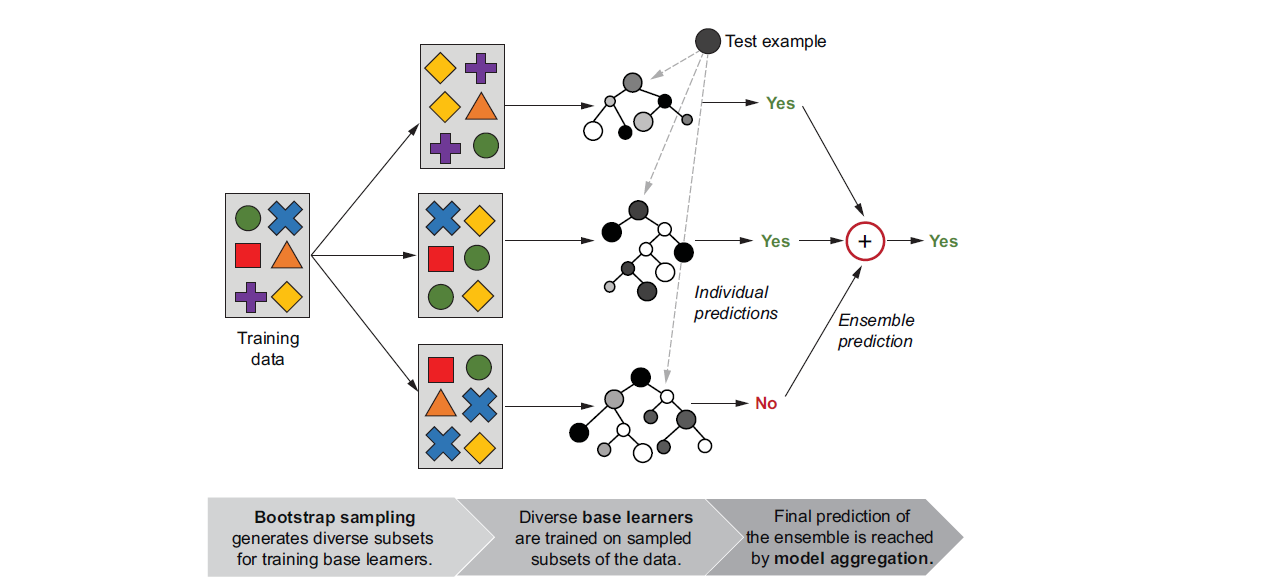

##Setup

In [19]:
!wget https://github.com/gkunapuli/ensemble-methods-notebooks/raw/master/plot_utils.py

--2023-06-07 09:56:43--  https://github.com/gkunapuli/ensemble-methods-notebooks/raw/master/plot_utils.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/gkunapuli/ensemble-methods-notebooks/master/plot_utils.py [following]
--2023-06-07 09:56:43--  https://raw.githubusercontent.com/gkunapuli/ensemble-methods-notebooks/master/plot_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3281 (3.2K) [text/plain]
Saving to: ‘plot_utils.py.1’

plot_utils.py.1     100%[===================>]   3.20K  --.-KB/s    in 0s      

2023-06-07 09:56:43 (27.7 MB/s) - ‘plot_utils.py.1’ saved [3281/3281]



In [20]:
import time
import os
import pickle
import numpy as np

from scipy.stats import mode

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from plot_utils import plot_2d_data, plot_2d_classifier

%matplotlib inline
import matplotlib.pyplot as plt

##Custom Bagging

A custom bagging ensemble is trained independently
using the following steps:

* Generate a bootstrap sample from the original data set.
* Fit a base estimator to the bootstrap sample.

In [21]:
def bagging_fit(X, y, n_estimators, max_depth=5, max_samples=200):
  n_examples = len(y)
  estimators = [DecisionTreeClassifier(max_depth=max_depth) for _ in range(n_estimators)]
  for tree in estimators:
    # Generate a bootstrap sample
    bagging = np.random.choice(n_examples, max_samples, replace=True)
    # Fits a base estimator to the bootstrap sample
    tree.fit(X[bagging, :], y[bagging])
  return estimators

In [22]:
def bagging_predict(X, estimators):
  all_predictions = np.array([tree.predict(X) for tree in estimators])
  # Makes the final predictions by majority voting
  y_pred, _ = mode(all_predictions, axis=0, keepdims=False)
  return np.squeeze(y_pred) 

In [23]:
# let's test our implementation on 2D data and visualize the results
random_state = np.random.RandomState(seed=4190)

X, y = make_moons(n_samples=300, noise=.25, random_state=random_state)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)

bagging_ensemble = bagging_fit(x_train, y_train, n_estimators=500, max_depth=12, max_samples=300)
y_pred = bagging_predict(x_test, bagging_ensemble)
print(accuracy_score(y_test, y_pred))

0.898989898989899


In [24]:
ensemble_accuracy = accuracy_score(y_test, y_pred)
print(f"Bagging: Holdout accuracy = {ensemble_accuracy * 100:4.2f}")

Bagging: Holdout accuracy = 89.90


In [25]:
single_tree = DecisionTreeClassifier(max_depth=12)
y_pred_single = single_tree.fit(x_train, y_train).predict(x_test)

single_tree_accuracy = accuracy_score(y_test, y_pred_single)
print(f"Single Decision Tree: Holdout test accuracy = {single_tree_accuracy * 100:4.2f}")

Single Decision Tree: Holdout test accuracy = 88.89


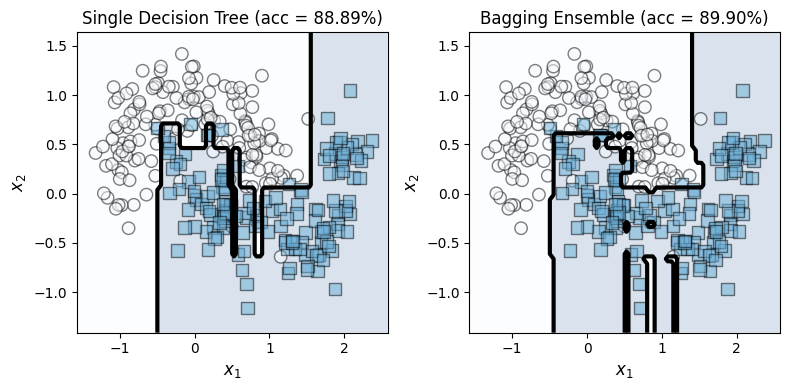

In [26]:
# let's visualize the difference between the bagging classifier and a single decision tree
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

title = 'Single Decision Tree (acc = {0:4.2f}%)'.format(single_tree_accuracy*100)
plot_2d_classifier(ax[0], X, y, colormap='Blues', alpha=0.15, s=80,
                   predict_function=single_tree.predict,
                   xlabel='$x_1$', ylabel='$x_2$', title=title)

title = 'Bagging Ensemble (acc = {0:4.2f}%)'.format(ensemble_accuracy*100)
plot_2d_classifier(ax[1], X, y, colormap='Blues', alpha=0.15, s=80,
                   predict_function=bagging_predict, predict_args=(bagging_ensemble),
                   xlabel='$x_1$', ylabel='$x_2$', title=title)

fig.tight_layout()

##Bagging

In [28]:
base_estimator = DecisionTreeClassifier(max_depth=10)
bagging_ensemble = BaggingClassifier(estimator=base_estimator, 
                            n_estimators=500, 
                            max_samples=100, 
                            oob_score=True, 
                            random_state=random_state)
bagging_ensemble.fit(x_train, y_train)
y_pred = bagging_ensemble.predict(x_test)

In [29]:
# let's obtain the OOB score
bagging_ensemble.oob_score_

0.9402985074626866

In [30]:
# let's see generalization on the test set
accuracy_score(y_test, y_pred)

0.9292929292929293

We can visualize the smoothing behavior of the `BaggingClassifier` by comparing its decision boundary to its component base `DecisionTreeClassifiers`.

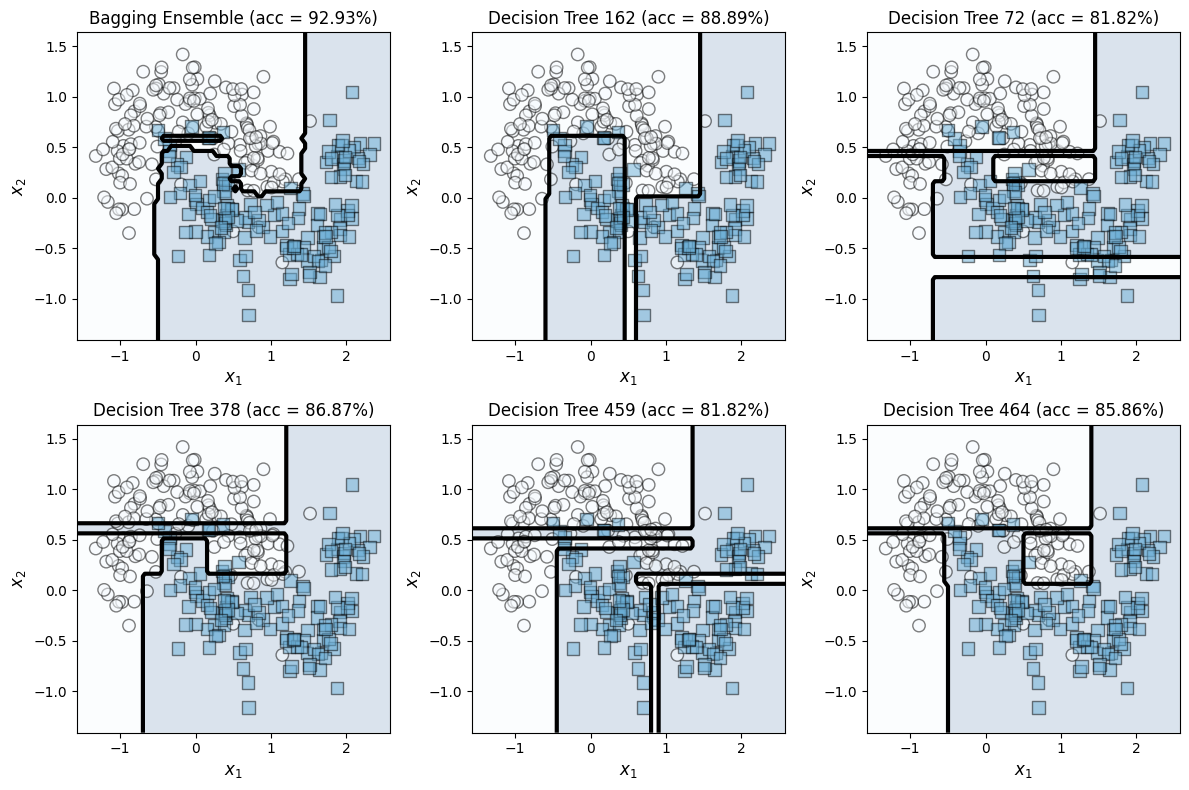

In [31]:
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
trees_to_plot = np.random.choice(500, 5, replace=True)

title = 'Bagging Ensemble (acc = {0:4.2f}%)'.format(accuracy_score(y_test, y_pred)*100)
plot_2d_classifier(ax[0, 0], X, y, colormap='Blues', alpha=0.15, s=80,
                   predict_function=bagging_ensemble.predict, 
                   xlabel='$x_1$', ylabel='$x_2$', title=title)

for i in range(5):
    r, c = np.divmod(i + 1, 3)  # Get the row and column index of the subplot
    j = trees_to_plot[i]
    
    tst_acc_clf = accuracy_score(y_test, bagging_ensemble[j].predict(x_test))
    
    bag = bagging_ensemble.estimators_samples_[j] 
    X_bag = X[bag, :]
    y_bag = y[bag]
    
    title = 'Decision Tree {1} (acc = {0:4.2f}%)'.format(tst_acc_clf*100, j+1)
    plot_2d_classifier(ax[r, c], X, y, colormap='Blues', alpha=0.15, s=80,
                       predict_function=bagging_ensemble[j].predict, 
                       xlabel='$x_1$', ylabel='$x_2$', title=title)

fig.tight_layout()

##Faster training with parallelization

Alternately, you can specify the number of concurrent processes by setting `n_jobs`.

In [38]:
!rm -rf data
!mkdir data

In [39]:
# See if the result file for this experiment already exists, and if not, rerun and save a new set of results
if not os.path.exists('data/SeqentialVsParallelBagging.pickle'):
    n_estimator_range = np.arange(50, 525, 50, dtype=int)
    n_range = len(n_estimator_range)
    n_runs = 10

    run_time_seq = np.zeros((n_runs, n_range))
    run_time_par = np.zeros((n_runs, n_range))

    base_estimator = DecisionTreeClassifier(max_depth=5)
    for r in range(n_runs):
        # Split the data randomly into training and test for this run
        X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=100)

        # Learn and evaluate this train/test split for this run with sequential bagging
        for i, n_estimators in enumerate(n_estimator_range):
            start = time.time()
            bag_ens = BaggingClassifier(estimator=base_estimator, 
                                        n_estimators=n_estimators, 
                                        max_samples=100, oob_score=True, n_jobs=1)
            bag_ens.fit(X_trn, y_trn)
            run_time_seq[r, i] = time.time() - start        

         # Learn and evaluate this train/test split for this run
        for i, n_estimators in enumerate(n_estimator_range):
            start = time.time()
            bag_ens = BaggingClassifier(estimator=base_estimator, 
                                        n_estimators=n_estimators, 
                                        max_samples=100, oob_score=True, n_jobs=-1)
            bag_ens.fit(X_trn, y_trn)
            run_time_par[r, i] = time.time() - start
            
    results = (run_time_seq, run_time_par)
    
    with open('./data/SeqentialVsParallelBagging.pickle', 'wb') as result_file:
        pickle.dump(results, result_file)

else:
    with open('./data/SeqentialVsParallelBagging.pickle', 'rb') as result_file:
        (run_time_seq, run_time_par) = pickle.load(result_file) 

Once the sequential vs. parallel results have been loaded/run, plot them.

<ipython-input-40-b47d8a3aa35a>:7: RuntimeWarning: Mean of empty slice
  run_time_seq_mean = np.nanmean(run_time_seq_adj, axis=0)
<ipython-input-40-b47d8a3aa35a>:11: RuntimeWarning: Mean of empty slice
  run_time_par_mean = np.nanmean(run_time_par_adj, axis=0)


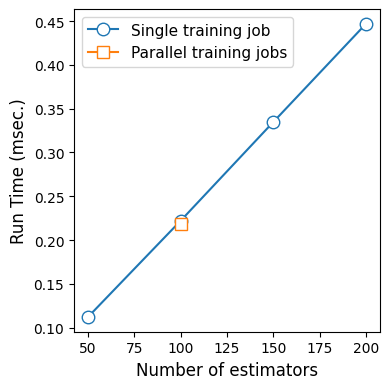

In [40]:
%matplotlib inline

n_estimator_range = np.arange(50, 525, 50, dtype=int)

run_time_seq_adj = np.copy(run_time_seq)
run_time_seq_adj[run_time_seq > 0.5] = np.nan
run_time_seq_mean = np.nanmean(run_time_seq_adj, axis=0)

run_time_par_adj = np.copy(run_time_par)
run_time_par_adj[run_time_par > 0.3] = np.nan
run_time_par_mean = np.nanmean(run_time_par_adj, axis=0)

fig = plt.figure(figsize=(4, 4))

plt.plot(n_estimator_range, run_time_seq_mean, linewidth=1.5, marker='o', markersize=9, mfc='w');
plt.plot(n_estimator_range[1:], run_time_par_mean[1:], linewidth=1.5, marker='s', markersize=9, mfc='w');
plt.ylabel('Run Time (msec.)', fontsize=12)
plt.xlabel('Number of estimators', fontsize=12)
plt.legend(['Single training job', 'Parallel training jobs'], fontsize=11, loc='upper left');

fig.tight_layout()